<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Organizing_memories_for_generalization_in_complementary_learning_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run 1/1
Generating offline training data from notebook reactivations...
Epoch 0/500
Epoch 10/500
Epoch 20/500
Epoch 30/500
Epoch 40/500
Epoch 50/500
Epoch 60/500
Epoch 70/500
Epoch 80/500
Epoch 90/500
Epoch 100/500
Epoch 110/500
Epoch 120/500
Epoch 130/500
Epoch 140/500
Epoch 150/500
Epoch 160/500
Epoch 170/500
Epoch 180/500
Epoch 190/500
Epoch 200/500
Epoch 210/500
Epoch 220/500
Epoch 230/500
Epoch 240/500
Epoch 250/500
Epoch 260/500
Epoch 270/500
Epoch 280/500
Epoch 290/500
Epoch 300/500
Epoch 310/500
Epoch 320/500
Epoch 330/500
Epoch 340/500
Epoch 350/500
Epoch 360/500
Epoch 370/500
Epoch 380/500
Epoch 390/500
Epoch 400/500
Epoch 410/500
Epoch 420/500
Epoch 430/500
Epoch 440/500
Epoch 450/500
Epoch 460/500
Epoch 470/500
Epoch 480/500
Epoch 490/500
Calculating training and test errors mediated by notebook...
Starting Training...
Epoch 0/500
Epoch 10/500
Epoch 20/500
Epoch 30/500
Epoch 40/500
Epoch 50/500
Epoch 60/500
Epoch 70/500
Epoch 80/500
Epoch 90/500
Epoch 100/500
Epoch 110/500


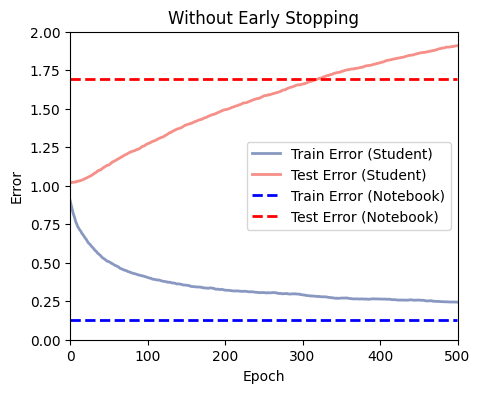

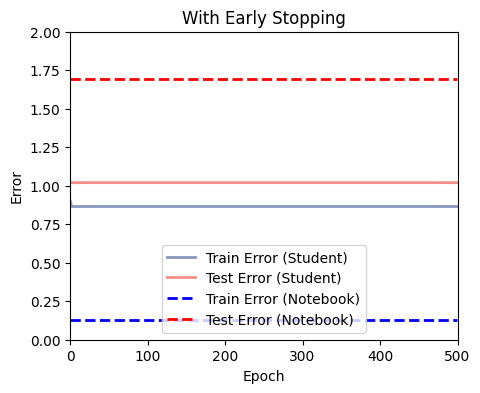

In [59]:
# Main code for Student-Teacher-Notebook framework

import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

################ パラメータ
r_n = 1  # number of repeats      [例：20]
nepoch = 500                    # [例：2000]
learnrate = 0.015               # [例：0.015]
N_x_t = 100  # 入力次元（教師） # [例：100]
N_y_t = 1  # 出力次元（教師）   # [例：1]
P = 100  # 例題数               # [例：100]
P_test = 1000  # テスト数       # [例：1000]

################ SNRに基づいて教師ネットワークの重み（variance_w）と出力ノイズ（variance_e）の分散の合計が 1 になるように設定
# Signal-to-Noise Ratio (SNR) を設定
SNR = float('0.05')             # [例：inf, 4, 0.05]
# SNRが無限大（ノイズが非常に小さい状態）の場合
if SNR == float('inf'):
    variance_w = 1  # 教師の重みの分散
    variance_e = 0  # 出力ノイズの分散はゼロ
else:
    # SNRが有限の場合の設定
    variance_w = SNR / (SNR + 1)  # 教師の重みの分散
    variance_e = 1 / (SNR + 1)    # 出力ノイズの分散

################# 生徒と教師は同じ次元数
N_x_s = N_x_t
N_y_s = N_y_t

################# ノートブックのパラメータ
# see Buhmann, Divko, and Schulten, 1989 for details regarding gamma and U terms
M = 500  # ノートブックのユニット数          [例：2000]
a = 0.05  # notebook sparseness              [例：0.05]
gamma = 0.6  # inhibition parameter          [例：0.6]
U = -0.15  # threshold for unit activation   [例：-0.15]
ncycle = 5  # 再帰サイクルの回数             [例：9]

#################  訓練誤差，テスト誤差，再活性化誤差を格納するためのメトリック（ノートブックによって駆動される）
# Early stopping なし
train_error_all = np.zeros((r_n, nepoch)) # 訓練誤差（生徒）
test_error_all = np.zeros((r_n, nepoch)) # テスト誤差（生徒）
N_train_error_all = np.zeros((r_n, nepoch)) # 訓練誤差（ノートブック）
N_test_error_all = np.zeros((r_n, nepoch)) # テスト誤差（ノートブック）

# Early stopping あり
train_error_early_stop_all = np.zeros((r_n, nepoch))
test_error_early_stop_all = np.zeros((r_n, nepoch))



################ r_n 回シミュレーションを実行
for r in range(r_n):
    print(f'Run {r + 1}/{r_n}')
    torch.manual_seed(r)

    error_train_vector = np.zeros(nepoch)
    error_test_vector = np.zeros(nepoch)
    error_react_vector = np.zeros(nepoch)

    ######### 教師ネットワーク
    W_t = torch.normal(0, variance_w**0.5, size=(N_x_t, N_y_t)) # variance_w で教師の重みを設定
    noise_train = torch.normal(0, variance_e**0.5, size=(P, N_y_t)) # ラベルノイズの分散を設定

    # 訓練データ
    x_t_input = torch.normal(0, (1/N_x_t)**0.5, size=(P, N_x_t)) # 入力
    y_t_output = x_t_input @ W_t + noise_train # 出力
    # テストデータ
    noise_test = torch.normal(0, variance_e**0.5, size=(P_test, N_y_t))
    x_t_input_test = torch.normal(0, (1/N_x_t)**0.5, size=(P_test, N_x_t))
    y_t_output_test = x_t_input_test @ W_t + noise_test

    ######### ノートブックネットワーク
    # sparseness a で，P 個のランダムなバイナリインデックス（0または1）を生成
    N_patterns = torch.zeros(P, M, dtype=torch.bool) # M はノートブックのユニット数
    for n in range(P):
        N_patterns[n, torch.randperm(M)[:int(M*a)]] = 1  # torch.randperm(M) は 0 から M-1 までのランダムな整数を返す

    ##### ヘブ学習によるノートブックの再帰重み W_N の計算
    # (N_patterns_float - a) は各パターンから sparseness a を引いたもの
    # その転置行列と掛け算して，正規化定数で割る
    W_N = (N_patterns.float() - a).T @ (N_patterns.float() - a) / (M * a * (1 - a))
    W_N = W_N - gamma / (a * M)  # add global inhibiton term, see Buhmann, Divko, and Schulten, 1989
    W_N.fill_diagonal_(0) # 自己結合を削除（対角成分を 0 に設定）


    #####  ヘブ学習によるノートブックと生徒の重みの計算（双方向）
    ### ノートブックから生徒の重み（生徒の再活性化）
    W_N_S_Lin = (N_patterns.float() - a).T @ x_t_input / (M * a * (1 - a)) # 入力用．ノートブックパターンから sparseness a を引いたものと，訓練入力 x_t_input を掛け算
    W_N_S_Lout = (N_patterns.float() - a).T @ y_t_output / (M * a * (1 - a)) # 出力用．ノートブックパターンから sparseness a を引いたものと，訓練出力 y_t_output を掛け算

    ### 生徒からノートブックへの重み（部分的な手がかりを提供）
    W_S_N_Lin = x_t_input.T @ (N_patterns.float() - a) # 入力用．訓練入力 x_t_input と，ノートブックパターンから sparseness a を引いたものを掛け算
    W_S_N_Lout = y_t_output.T @ (N_patterns.float() - a) # 出力用．訓練出力 y_t_output と，ノートブックパターンから sparseness a を引いたものを掛け算

    ######### 生徒ネットワーク
    W_s = torch.normal(0, 0**0.5, size=(N_x_s, N_y_s)) # 生徒の重み W_s をゼロ初期化

    ######### オフライン訓練データの作成
    # ノートブックの再活性化から訓練データを作成
    # ノートブックパターンの再活性化結果を保存するための配列を初期化．速度を考慮してすべてのエポックで事前計算
    N_patterns_reactivated = torch.zeros(P, M, nepoch, dtype=torch.bool)

    print("Generating offline training data from notebook reactivations...")
    # ノートブックパターンの再活性化を生成
    for m in range(nepoch):
        if m % 10 == 0:
            print(f"Epoch {m}/{nepoch}")
        # Notebook pattern completion through recurrent dynamis
        # % Code below simulates hippocampal offline spontanenous
        # % reactivations by seeding the initial notebook state with a random
        # % binary pattern, then notebook goes through a two-step retrieval
        # % process: (1) Retrieving a pattern using dynamic threshold to
        # % ensure a pattern with sparseness a is retrieved (otherwise a silent
        # % attractor will dominate retrieval). (2) Using the
        # % retrieved pattern from (1) to seed a second round of pattern
        # % completion using a fixed-threshold method (along with a global
        # % inhibition term during encoding), so the retrieved patterns are
        # % not forced to have a fixed sparseness, in addition, there is a
        # % "silent  state" attractor when the seeding pattern lies far away
        # % from any of the encoded patterns.

        ####### 動的な閾値による，再帰サイクルの開始
        # 再活性化パターンを初期化
        Activity_dyn_t = torch.zeros(P, M, dtype=torch.float32)

        ##### 再帰活性化サイクルによる最初のパターンの生成
        # 初期の入力としてランダムパターンを使用
        for cycle in range(ncycle):
            if cycle <= 1:
                clamp = 1  # 最初の2サイクルではランダムパターンを強制する
            else:
                clamp = 0  # それ以降はランダムパターンの影響を減らす

            rand_patt = torch.rand(P, M) <= a # random seeding activity
            # ノートブックをランダムパターンでシーディング
            M_input = Activity_dyn_t + (rand_patt.float() * clamp)
            # ノートブックをオリジナルパターンでシーディング
            # M_input = Activity_dyn_t + (N_patterns.float() * clamp);

            # 現在の状態を計算
            M_current = M_input @ W_N
            # 出力を 0 から 1 の範囲にスケーリング
            scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
            M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)
            # スパース性に基づいた閾値を決定
            sorted_M_current = M_current.sort(dim=1, descending=True)[0]
            t_ind = torch.tensor(M * a).floor().int()
            t_ind[t_ind < 1] = 1
            t = sorted_M_current[torch.arange(P), t_ind - 1] # threshold for unit activations
            Activity_dyn_t = (M_current >= t.unsqueeze(1))

        Activity_dyn_t = Activity_dyn_t.float()


        ####### 固定した閾値による，パターンの作成の第二ラウンド
        Activity_fix_t = torch.zeros(P, M, dtype=torch.float32)
        for cycle in range(ncycle):
            if cycle <= 1:
                clamp = 1  # 最初の 2 サイクルでは動的な閾値の影響を強制する
            else:
                clamp = 0  # それ以降は動的な閾値の影響を減らす

            M_input = Activity_fix_t + Activity_dyn_t.float() * clamp
            # 現在の状態を計算
            M_current = M_input @ W_N
            # 固定閾値 U を用いてパターンを完成
            Activity_fix_t = M_current >= U  # U is the fixed threshold
        # 取得したパターンを保存
        N_patterns_reactivated[:, :, m] = Activity_fix_t.bool()

    # % Seeding notebook with original notebook patterns for calculating
    # % training error mediated by notebook (seeding notebook with student
    # % input via Student's input to Notebook weights, once pattern completion
    # % finishes, use the retrieved pattern to activate Student's output unit
    # % via Notebook to Student's output weights.

    print("Calculating training and test errors mediated by notebook...")

    # 初期化: ノートブックの活動を格納するテンソル
    Activity_notebook_train = torch.zeros(P, M, dtype=torch.float32)
    ##### ノートブックのパターン完成のための再活性化サイクル
    for cycle in range(ncycle):
        if cycle <= 1:
            clamp = 1
        else:
            clamp = 0

        # 生徒の入力からノートブックへの重みを使用してシードパターンを計算（x_t_input は訓練データの入力）
        seed_patt = x_t_input @ W_S_N_Lin
        # ノートブックへの入力としてシードパターンを追加
        M_input = Activity_notebook_train + seed_patt * clamp

        # ノートブックの活動を更新
        M_current = M_input @ W_N

        # 活動を 0 と 1 の間にスケーリング
        scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
        M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)

        # 活動のソートと閾値の計算
        sorted_M_current = M_current.sort(dim=1, descending=True)[0]
        t_ind = torch.tensor(M * a).floor().int()
        t_ind[t_ind < 1] = 1
        t = sorted_M_current[torch.arange(P), t_ind - 1]

        # 閾値に基づいて活動をバイナリに変換
        Activity_notebook_train = M_current >= t.unsqueeze(1)

    # ノートブックの活動を用いて学生の出力を計算
    N_S_output_train = Activity_notebook_train.float() @ W_N_S_Lout
    # ノートブックの訓練誤差を計算
    delta_N_train = y_t_output - N_S_output_train
    error_N_train = (delta_N_train ** 2).sum().item() / P

    # ノートブックの誤差はトレーニング中ずっと一定なので，各エポックに同じ誤差の値を入れる
    error_N_train_vector = np.ones(nepoch) * error_N_train
    N_train_error_all[r, :] = error_N_train_vector


    # ノートブックのテストデータの活動を初期化
    Activity_notebook_test = torch.zeros(P_test, M, dtype=torch.float32)
    ####### ノートブックのパターン完成のための再活性化サイクル
    for cycle in range(ncycle):
        if cycle <= 1:
            clamp = 1
        else:
            clamp = 0
        # テストデータからノートブックへの重みを使用してシードパターンを計算
        seed_patt = x_t_input_test @ W_S_N_Lin
        # ノートブックへの入力としてシードパターンを追加
        M_input = Activity_notebook_test + seed_patt * clamp

        # ノートブックの活動を更新
        M_current = M_input @ W_N

        # 活動を0と1の間にスケーリング
        scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
        M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)

        # 活動のソートと閾値の計算
        sorted_M_current = M_current.sort(dim=1, descending=True)[0]
        t_ind = torch.tensor(M * a).floor().int()
        t_ind[t_ind < 1] = 1
        t = sorted_M_current[torch.arange(P_test), t_ind - 1]

        # 閾値に基づいて活動をバイナリに変換
        Activity_notebook_test = M_current >= t.unsqueeze(1)

    # ノートブックの活動を用いてテスト出力を計算
    N_S_output_test = torch.matmul(Activity_notebook_test.float(), W_N_S_Lout)
    # ノートブックのテスト誤差を計算
    delta_N_test = y_t_output_test - N_S_output_test
    error_N_test = (delta_N_test ** 2).sum().item() / P_test

    # エポックごとに同じ誤差の値を設定
    error_N_test_vector = np.ones(nepoch) * error_N_test
    N_test_error_all[r, :] = error_N_test_vector

    ######## 各エポックにおける，オフラインノートブック再活性化による生徒のトレーニング
    print("Starting Training...")
    for m in range(nepoch):
        if m % 10 == 0:
            print(f"Epoch {m}/{nepoch}")

        #### ノートブック再活性化に基づく生徒の入力と出力の計算
        N_S_input = N_patterns_reactivated[:, :, m].float() @ W_N_S_Lin
        N_S_output = N_patterns_reactivated[:, :, m].float() @ W_N_S_Lout

        ####  生徒ネットワークによる予測
        N_S_prediction = N_S_input @ W_s # ノートブック再活性化入力を用いた，生徒の予測出力
        S_prediction = x_t_input @ W_s # 実際の訓練入力を用いた，生徒の予測出力
        S_prediction_test = x_t_input_test @ W_s # 実際のテスト入力を用いた，生徒の予測出力

        ####  訓練エラーの計算
        delta_train = y_t_output - S_prediction
        error_train = (delta_train ** 2).sum().item() / P
        error_train_vector[m] = error_train

        ####  汎化誤差の計算
        delta_test = y_t_output_test - S_prediction_test
        error_test = (delta_test ** 2).sum().item() / P_test
        error_test_vector[m] = error_test

        #### 勾配降下法による重みの更新
        w_delta = N_S_input.T @ N_S_output - N_S_input.T @ N_S_input @ W_s
        W_s = W_s + learnrate * w_delta

    # 訓練誤差とテスト誤差の保存
    train_error_all[r, :] = error_train_vector
    test_error_all[r, :] = error_test_vector

    ###### Early stopping
    # 最小のテスト誤差とそのエポックを見つける
    min_v, min_p = torch.min(torch.tensor(error_test_vector), 0)

    # Early stopping による誤差の更新
    train_error_early_stop = error_train_vector.copy()
    train_error_early_stop[min_p + 1:] = error_train_vector[min_p]
    test_error_early_stop = error_test_vector.copy()
    test_error_early_stop[min_p + 1:] = error_test_vector[min_p]

    # Early stopping によるエラーを保存
    train_error_early_stop_all[r, :] = train_error_early_stop
    test_error_early_stop_all[r, :] = test_error_early_stop


###### Plotting
color_scheme = [(137 / 255, 152 / 255, 193 / 255), (245 / 255, 143 / 255, 136 / 255)]
line_w = 2
font_s = 12

# Early stopping なし
plt.figure(1)
plt.plot(range(nepoch), np.mean(train_error_all, axis=0), color=color_scheme[0], linewidth=line_w, label='Train Error (Student)')
plt.plot(range(nepoch), np.mean(test_error_all, axis=0), color=color_scheme[1], linewidth=line_w, label='Test Error (Student)')
plt.plot(range(nepoch), np.mean(N_train_error_all, axis=0), 'b--', linewidth=2, label='Train Error (Notebook)')
plt.plot(range(nepoch), np.mean(N_test_error_all, axis=0), 'r--', linewidth=2, label='Test Error (Notebook)')
plt.xlabel('Epoch', color='k')
plt.ylabel('Error', color='k')
plt.xlim([0, nepoch])
plt.ylim([0, 2])
plt.legend()
plt.title('Without Early Stopping', fontsize=font_s)
plt.gcf().set_size_inches(5, 4)
plt.show()

# Early stopping あり
plt.figure(2)
plt.plot(range(nepoch), np.mean(train_error_early_stop_all, axis=0), color=color_scheme[0], linewidth=line_w, label='Train Error (Student)')
plt.plot(range(nepoch), np.mean(test_error_early_stop_all, axis=0), color=color_scheme[1], linewidth=line_w, label='Test Error (Student)')
plt.plot(range(nepoch), np.mean(N_train_error_all, axis=0), 'b--', linewidth=line_w, label='Train Error (Notebook)')
plt.plot(range(nepoch), np.mean(N_test_error_all, axis=0), 'r--', linewidth=line_w, label='Test Error (Notebook)')
plt.xlabel('Epoch', color='k')
plt.ylabel('Error', color='k')
plt.xlim([0, nepoch])
plt.ylim([0, 2])
plt.legend()
plt.title('With Early Stopping', fontsize=font_s)
plt.gcf().set_size_inches(5, 4)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


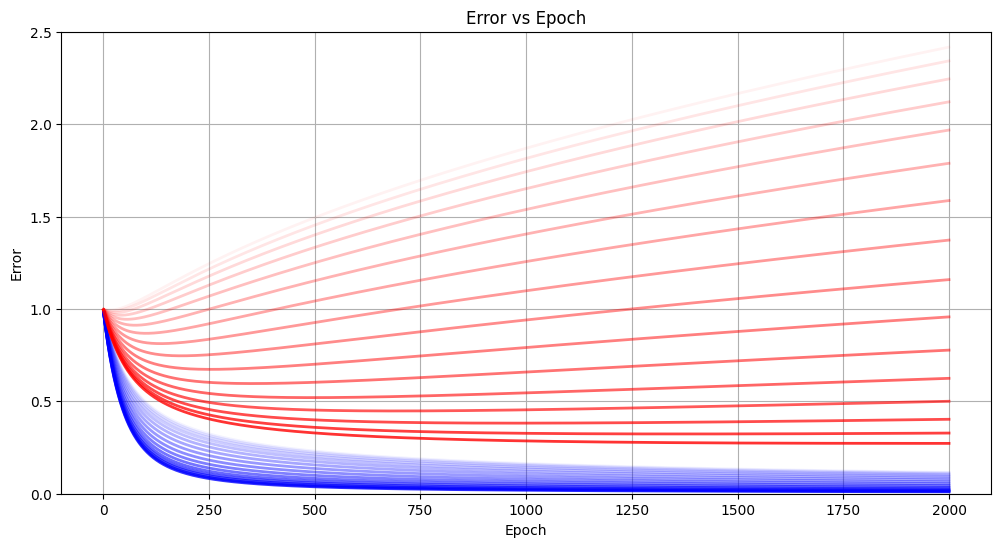

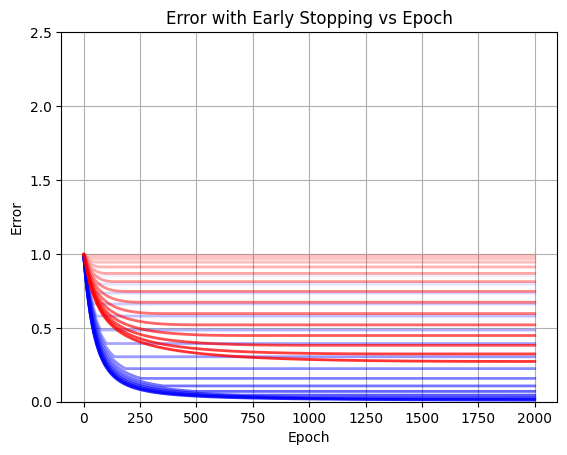

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# ハイパーパラメータの設定
nepoch = 2000
learnrate = 0.005
N_x_t = 100
N_y_t = 1
P = 100
M = 5000  # ノートブックのユニット数

SNR_log_interval = np.arange(-4, 4.5, 0.5)
SNR_vec = 2**SNR_log_interval

Notebook_Train = (P-1)/(M-1)  # ノートブックの訓練誤差の解析解


plt.figure(figsize=(12, 6))

for count, SNR in enumerate(SNR_vec):
    print(count + 1)

    Eg = []
    Et = []
    lr = learnrate

    # SNRに基づいて教師ネットワークの重み（variance_w）と出力ノイズ（variance_e）の分散の合計が 1 になるように設定
    if SNR == float('inf'):
        variance_w = 1
        variance_e = 0
    else:
        variance_w = SNR / (SNR + 1)
        variance_e = 1 / (SNR + 1)

    alpha = P / N_x_t  # 入力次元で割った例題数

    for t in range(1, nepoch + 1):
        def train(lam):
            term = np.sqrt(((alpha**0.5 + 1)**2 - lam) * (lam - (alpha**0.5 - 1)**2))
            return (term / (lam * 2 * np.pi)) * (lam * variance_w + variance_e) * np.exp(-2 * lam * t / (1 / lr))

        def test(lam):
            term = np.sqrt(((alpha**0.5 + 1)**2 - lam) * (lam - (alpha**0.5 - 1)**2))
            return (term / (lam * 2 * np.pi)) * (np.exp(-2 * lam * t / (1 / lr)) + ((1 - np.exp(-lam * t / (1 / lr)))**2) / (lam * SNR))

        Et_val, _ = quad(train, (alpha**0.5 - 1)**2, (alpha**0.5 + 1)**2)
        Et.append((1 / alpha) * (Et_val + (alpha < 1) * (1 - alpha) * variance_e) + (1 - 1 / alpha) * variance_e)

        Eg_val, _ = quad(test, (alpha**0.5 - 1)**2, (alpha**0.5 + 1)**2)
        Eg.append(variance_w * (Eg_val + (alpha < 1) * (1 - alpha) + 1 / SNR))

    # Early stopping 曲線
    min_Eg_idx = np.argmin(Eg)
    Eg_early_stop = np.copy(Eg)
    Eg_early_stop[min_Eg_idx + 1:] = Eg[min_Eg_idx]

    Et_early_stop = np.copy(Et)
    Et_early_stop[min_Eg_idx + 1:] = Et[min_Eg_idx]

    # 訓練誤差の値を選択し，Memory の汎化スコアに変換
    better_train_no_early_stop = np.minimum(Et, np.ones(nepoch) * Notebook_Train)
    control_curve = (Et[0] - better_train_no_early_stop) / Et[0]
    lesion_curve = (Et[0] - Et) / Et[0]

    better_train_yes_early_stop = np.minimum(Et_early_stop, np.ones(nepoch) * Notebook_Train)
    control_curve_early_stop = (Et_early_stop[0] - better_train_yes_early_stop) / Et_early_stop[0]
    lesion_curve_early_stop = (Et_early_stop[0] - Et_early_stop) / Et_early_stop[0]

    control_Eg_curve = (Eg[0] - Eg) / Eg[0]
    control_Eg_curve_early_stop = (Eg_early_stop[0] - Eg_early_stop) / Eg_early_stop[0]

    ##### plot
    plt.figure(1)
    plt.plot(range(1, nepoch + 1), Et, '-', color=(0, 0, 1, count / 20), linewidth=2)
    plt.plot(range(1, nepoch + 1), Eg, '-', color=(1, 0, 0, count / 20), linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.ylim([0, 2.5])
    plt.title('Error vs Epoch')
    plt.grid(True)

    plt.figure(2)
    plt.plot(range(1, nepoch + 1), Et_early_stop, '-', color=(0, 0, 1, count / 20), linewidth=2)
    plt.plot(range(1, nepoch + 1), Eg_early_stop, '-', color=(1, 0, 0, count / 20), linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.ylim([0, 2.5])
    plt.title('Error with Early Stopping vs Epoch')
    plt.grid(True)

plt.show()

# Fig.2 i & j, validation set approach

かなり時間がかかりそう

In [61]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [63]:
def vali_net(N,P,P_test,val_frac,SNR,nepoch,repeat):
    '''plot estimated generalization error and true generalization error as a function of train/val split ratio'''

    Et = np.zeros((nepoch,repeat))
    Ev = np.zeros((nepoch,repeat))
    Eg = np.zeros((nepoch,repeat))

    for r in range(repeat):
        #print(r)

        torch.manual_seed(r)


        if SNR == np.inf:
            variance_w = 1;
            variance_e = 0;
        else:
            variance_w = SNR/(SNR + 1);
            variance_e = 1/(SNR + 1);


        noise_train = torch.normal(0, variance_e**0.5, size = [P,1])
        noise_test = torch.normal(0, variance_e**0.5, size = [P_test,1])


        W_t = torch.normal(0, variance_w**0.5, size=(N, 1))

        # generate a pool of examples
        train_x_pool = torch.normal(0, (1/N)**0.5, size=(P, N))
        train_y_pool = torch.matmul(train_x_pool, W_t) + noise_train

        # generate test set
        test_x = torch.normal(0, (1/N)**0.5, size=(P_test, N))
        test_y = torch.matmul(test_x, W_t) + noise_test

        # split pool into train set and validation set
        vali_ind = np.random.choice(P, int(np.floor(P*val_frac)), replace=False)
        train_ind = np.setdiff1d(np.arange(P), vali_ind)

        train_x = train_x_pool[train_ind,:]
        train_y = train_y_pool[train_ind,:]


        vali_x = train_x_pool[vali_ind,:]
        vali_y = train_y_pool[vali_ind,:]

        model = nn.Sequential(nn.Linear(N,1,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=0.05*(N/2)) # to match the learnrate in the matlab implementation.

        with torch.no_grad():
            list(model.parameters())[0].zero_()

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(train_y, model(train_x))
            train_error.backward()
            optimizer.step()
            Et[i,r] = train_error.detach().numpy()
            with torch.no_grad():
                vali_error = criterion(vali_y, model(vali_x))
                test_error = criterion(test_y, model(test_x))
                Ev[i,r] = vali_error.numpy()
                Eg[i,r] = test_error.numpy()
    return Et,Ev,Eg



def criterion(y, y_hat):
    return (y - y_hat).pow(2).mean()

In [64]:
SNR_range = [0.05,4, np.inf]
nepoch = 1000
repeat = 100
N = 100
P_vec = [50,100,300,500,1000]
P_test = 1000
#val_frac_vec = [0.02,0.05,0.1,0.3,0.6,0.9]
val_frac_vec = np.arange(0.02,0.98,0.02)
snr_len = len(SNR_range)

Et_big = np.zeros((len(P_vec),len(val_frac_vec),snr_len,nepoch,repeat))
Ev_big = np.zeros((len(P_vec),len(val_frac_vec),snr_len,nepoch,repeat))
Eg_big = np.zeros((len(P_vec),len(val_frac_vec),snr_len,nepoch,repeat))

for p,P in enumerate(P_vec):
    print('P = ' + str(P))
    for f, frac in enumerate(val_frac_vec):
        print('frac = ' + str(frac))
        for i,SNR in enumerate(SNR_range):
            print('SNR = ' + str(SNR))
            Et_big[p,f,i,:,:],Ev_big[p,f,i,:,:],Eg_big[p,f,i,:,:]= vali_net(N,P,P_test,frac,SNR,nepoch,repeat)

P = 50
frac = 0.02
SNR = 0.05
SNR = 4
SNR = inf
frac = 0.04
SNR = 0.05
SNR = 4


KeyboardInterrupt: 

In [ ]:
n=58
Ev = Ev_big[1,4,1,:,n]
Eg = Eg_big[1,4,1,:,n]
Et = Et_big[1,4,1,:,n]

plt.figure(figsize = (4,4),dpi =600)
plt.plot(Eg,'r', label = 'Generalization',rasterized=False,zorder=1)
plt.scatter(np.argmin(Eg),Eg[np.argmin(Eg)],color = 'red',rasterized=False,zorder=2)
plt.plot(Ev,'g',label = 'Validation')
plt.scatter(np.argmin(Ev),Eg[np.argmin(Ev)],color = 'green',rasterized=False,zorder=2)
plt.plot(Et,'b', label = 'Memory',rasterized=False)


plt.xlabel('Epoch',fontsize = '14')
plt.ylabel('Error',fontsize = '14')
#plt.legend()

plt.savefig('fig2i.pdf')

In [ ]:
SNR_range = [0.05,4, np.inf]
nepoch = 1000
repeat = 100
N = 100
P_vec = [50,100,300,500,1000]
P_test = 1000
#val_frac_vec = [0.02,0.05,0.1,0.3,0.6,0.9]
val_frac_vec = np.arange(0.02,0.98,0.02)
snr_len = len(SNR_range)


mse_est = np.zeros((len(P_vec),len(val_frac_vec),len(SNR_range)))
gen_tru = np.zeros((len(P_vec),len(val_frac_vec),len(SNR_range)))
gen_est = np.zeros((len(P_vec),len(val_frac_vec),len(SNR_range)))

for p,P in enumerate(P_vec):

    for f, frac in enumerate(val_frac_vec):
    #%print('frac = ' + str(frac))
        for i,SNR in enumerate(SNR_range):

            mse_est[p,f,i] = ((np.min(Eg_big[p,f,i,:,:], axis = 0)-np.min(Ev_big[p,f,i,:,:], axis = 0))**2).mean()
            gen_tru [p,f,i] = np.min(Eg_big[p,f,i,:,:], axis = 0).mean()
            gen_est [p,f,i] = Eg_big[p,f,i,np.argmin(Ev_big[p,f,i,:,:],axis = 0),range(repeat)].mean()

In [ ]:
plt.figure(figsize = (4,4),dpi = 300)
for i in range(len(SNR_range)):
    plt.plot(val_frac_vec,gen_est[1,:,i],'g-',markersize= 3)
    #plt.scatter(val_frac_vec[np.nanargmin(gen_est[1,:,i])],gen_est[1,np.nanargmin(gen_est[1,:,i]),i],color = 'green')

    #plt.plot(val_frac_vec,gen_tru[1,:,i],'r-')
    plt.plot(val_frac_vec,np.full(val_frac_vec.shape,np.nanmin(gen_tru[i,:,i])),'k--')


plt.xlabel('Validation set fraction',fontsize = '14')
plt.ylabel('Error',fontsize = '14')
plt.savefig('fig2j.pdf')

In [ ]:
# plt.figure(figsize = (4,4),dpi = 300)
# for i in range(3):
#     plt.plot(val_frac_vec,gen_est[i,:,:].mean(axis = 1),'g-')
#     plt.plot(val_frac_vec,np.full(val_frac_vec.shape,np.nanmin(gen_tru[i,:,1])),'k--')

# plt.xlabel('Validation set fraction',fontsize = '14')
# plt.ylabel('Error',fontsize = '14')
# plt.ylim(0,1)
# plt.savefig('fig2_val_alpha.pdf')

# Fig 2. k-l

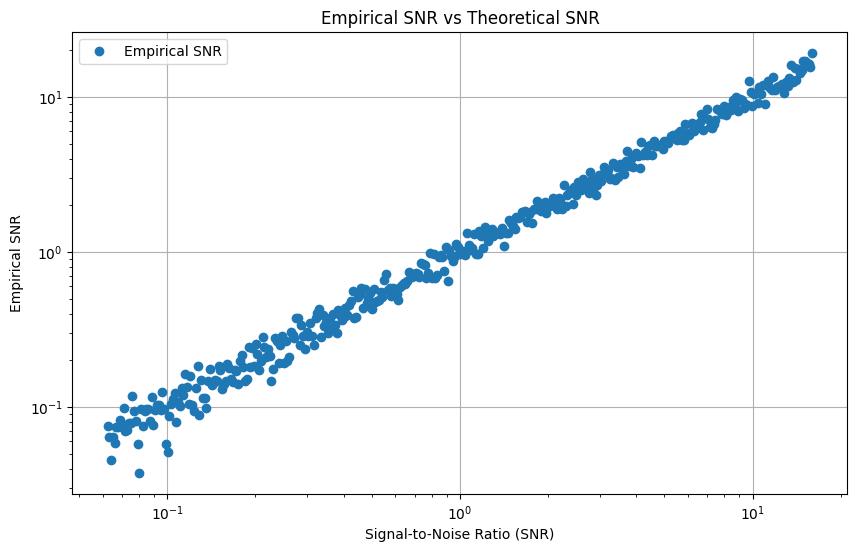

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.linalg import svd

np.random.seed(int(sum(100 * np.random.rand(1))))

# Construct an ensemble of teacher-generated student data
num_teachers = 1
N = 1000
P = 1000
std_X = np.sqrt(1 / N)

SNR_vec = np.arange(-4, 4.02, 0.02)
SNRs = 2 ** SNR_vec

num_SNRs = len(SNRs)

wbars = torch.empty(N, num_SNRs, num_teachers)
Xs = torch.empty(P, N, num_SNRs, num_teachers)
etas = torch.empty(P, num_SNRs, num_teachers)
ys = torch.empty(P, num_SNRs, num_teachers)

for s in range(num_SNRs):
    S = SNRs[s]
    std_noise = np.sqrt(1 / (1 + S))
    std_weights = np.sqrt(S / (1 + S))
    for t in range(num_teachers):
        wbars[:, s, t] = std_weights * torch.randn(N)
        Xs[:, :, s, t] = std_X * torch.randn(P, N)
        etas[:, s, t] = std_noise * torch.randn(P)
        ys[:, s, t] = torch.matmul(Xs[:, :, s, t], wbars[:, s, t]) + etas[:, s, t]

var_ys = torch.var(ys, unbiased=False, dim=0)
var_ws = torch.var(wbars, unbiased=False, dim=0)
var_noises = torch.var(etas, unbiased=False, dim=0)
empirical_SNRs = (var_ys - var_noises) / var_noises

mean_empirical_SNRs = torch.mean(empirical_SNRs, dim=1)
std_empirical_SNRs = torch.std(empirical_SNRs, unbiased=False, dim=1)

# plot
plt.figure(figsize=(10, 6))
plt.plot(SNRs, empirical_SNRs, 'o', label='Empirical SNR')
# plt.errorbar(SNRs, mean_empirical_SNRs, std_empirical_SNRs, linewidth=3, label='Mean Empirical SNR ± STD')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Empirical SNR')
plt.title('Empirical SNR vs Theoretical SNR')
plt.legend()
plt.grid(True)
plt.show()

計算が大変

In [ ]:
# Evaluate the log-likelihood function for each dataset using the SVD decomposition
Us = torch.empty(P, P, num_SNRs, num_teachers)
Ss = torch.empty(P, N, num_SNRs, num_teachers)
Vs = torch.empty(N, N, num_SNRs, num_teachers)
Lambdas = torch.empty(P, P, num_SNRs, num_teachers)
inv_Lambdas = torch.empty(P, P, num_SNRs, num_teachers)

for s in range(num_SNRs):
    for t in range(num_teachers):
        U, S, Vh = svd(Xs[:, :, s, t])
        Us[:, :, s, t] = U
        Ss[:, :, s, t] = torch.diag(S)
        Vs[:, :, s, t] = Vh.T
        Lambdas[:, :, s, t] = torch.diag(S)**2
        inv_Lambdas[:, :, s, t] = torch.linalg.pinv(Lambdas[:, :, s, t])

# More numerically efficient version
num_components = min(N, P)
SNR_vector = 2 ** np.arange(-6, 6.02, 0.02)
num_step_SNR = len(SNR_vector)

log_likelihood_function = torch.empty(num_step_SNR, num_SNRs, num_teachers)
max_log_likelihood = torch.empty(num_SNRs, num_teachers)
estimated_SNRs = torch.empty(num_SNRs, num_teachers)

for s in range(num_SNRs):
    for t in range(num_teachers):
        y_modes = torch.matmul(Us[:, :, s, t].T, ys[:, s, t])
        for i in range(num_step_SNR):
            inv_C_matrix_modes = (1 + SNR_vector[i]) * torch.eye(P)
            A1 = (P - num_components) / 2 * torch.log1p(torch.tensor(SNR_vector[i], dtype=torch.float32))
            A2 = 0
            for j in range(num_components):
                inv_C_matrix_modes[j, j] = (1 + SNR_vector[i]) / (1 + SNR_vector[i] * Lambdas[j, j, s, t])
                A1 += 0.5 * torch.log(inv_C_matrix_modes[j, j])
                A2 -= 0.5 * y_modes[j]**2 * inv_C_matrix_modes[j, j]
            if P > num_components:
                for j in range(P):
                    A2 -= 0.5 * y_modes[j]**2 * inv_C_matrix_modes[j, j]
            log_likelihood_function[i, s, t] = A1 + A2
        max_val, tmp_idx = torch.max(log_likelihood_function[:, s, t], dim=0)
        max_log_likelihood[s, t] = max_val
        estimated_SNRs[s, t] = SNR_vector[tmp_idx]

# Plot the log-likelihood functions
plt.figure(figsize=(10, 6))
plt.plot(SNR_vec, np.log2(estimated_SNRs[:, 0]), 'ok')
plt.xlabel('Log2(Signal-to-Noise Ratio)')
plt.ylabel('Log2(Estimated SNR)')
plt.title('Log2(Estimated SNR) vs Log2(SNR)')
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(SNR_vector, log_likelihood_function[:, -1, 0], label='Log-Likelihood Function')
plt.plot(SNRs[-1], max_log_likelihood[-1, 0], 'ob', label='Max Log-Likelihood')
plt.plot(estimated_SNRs[-1, 0], max_log_likelihood[-1, 0], 'or', linewidth=2, label='Estimated SNR')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Function vs SNR')
plt.legend()
plt.grid(True)
plt.show()

# Fig 2. m-n

In [9]:
import numpy as np
import torch
from torch import nn, optim
import scipy as sp
import scipy.integrate
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
from matplotlib import rc
#rc('text', usetex=True)
rc('font', size=14)

In [10]:
#pMP_nz = lambda lam: ((np.sqrt(np.maximum(0,(lam-lm)*(lp - lam)))/lam))/(2*np.pi) * (lam < lp) * (lam > lm)

def pMP_nz(lam):
    ret = np.zeros(lam.shape)
    inds = np.nonzero((lam <= lp) * (lam >= lm) * lam)
    ret[inds] = ((np.sqrt((lam[inds]-lm)*(lp - lam[inds]))/lam[inds]))/(2.*np.pi)
    return ret

def pMP_nz_scalar(lam):
    if lam > 0 and lam <= lp and lam >= lm:
        return (np.sqrt((lam-lm)*(lp - lam))/lam)/(2.*np.pi)
    else:
        return 0

def cutoff_prediction(gamma):
        return (1.-alpha)*(alpha<1.) + sp.integrate.quad(pMP_nz_scalar,0,gamma)[0] + (1./snr)*sp.integrate.quad(lambda x: pMP_nz_scalar(x)/x, gamma, np.inf)[0]



def training_error(t):
    point_err = lambda k: 1./alpha * sp.integrate.quad(lambda x: pMP_nz_scalar(x)*(x*(1 + inr) + 1./snr)*np.exp(-2*x*k/(tau*alpha)), 0, np.inf)[0] + 1./snr*(1.-1./alpha)*(alpha>1.)
    return np.array([point_err(x) for x in t])/(1+phi)

def training_error2(t):
    point_err = lambda k: 1./alpha * sp.integrate.quad(lambda x: pMP_nz_scalar(x)*(1+x*snr)/(1+snr)*np.exp(-2*x*k/(tau)), 0, np.inf)[0]
    return np.array([point_err(x) for x in t])

def test_error(t):
    point_err = lambda k: sp.integrate.quad(lambda x: pMP_nz_scalar(x)*((1 + inr)*np.exp(-2*x*k/(tau*alpha)) + 1./(x*snr)*(1-np.exp(-x*k/(tau*alpha)))**2), 0, np.inf)[0] + 1./snr + (1-alpha)*(alpha<1.)
    return np.array([point_err(x) for x in t])/(1+phi)

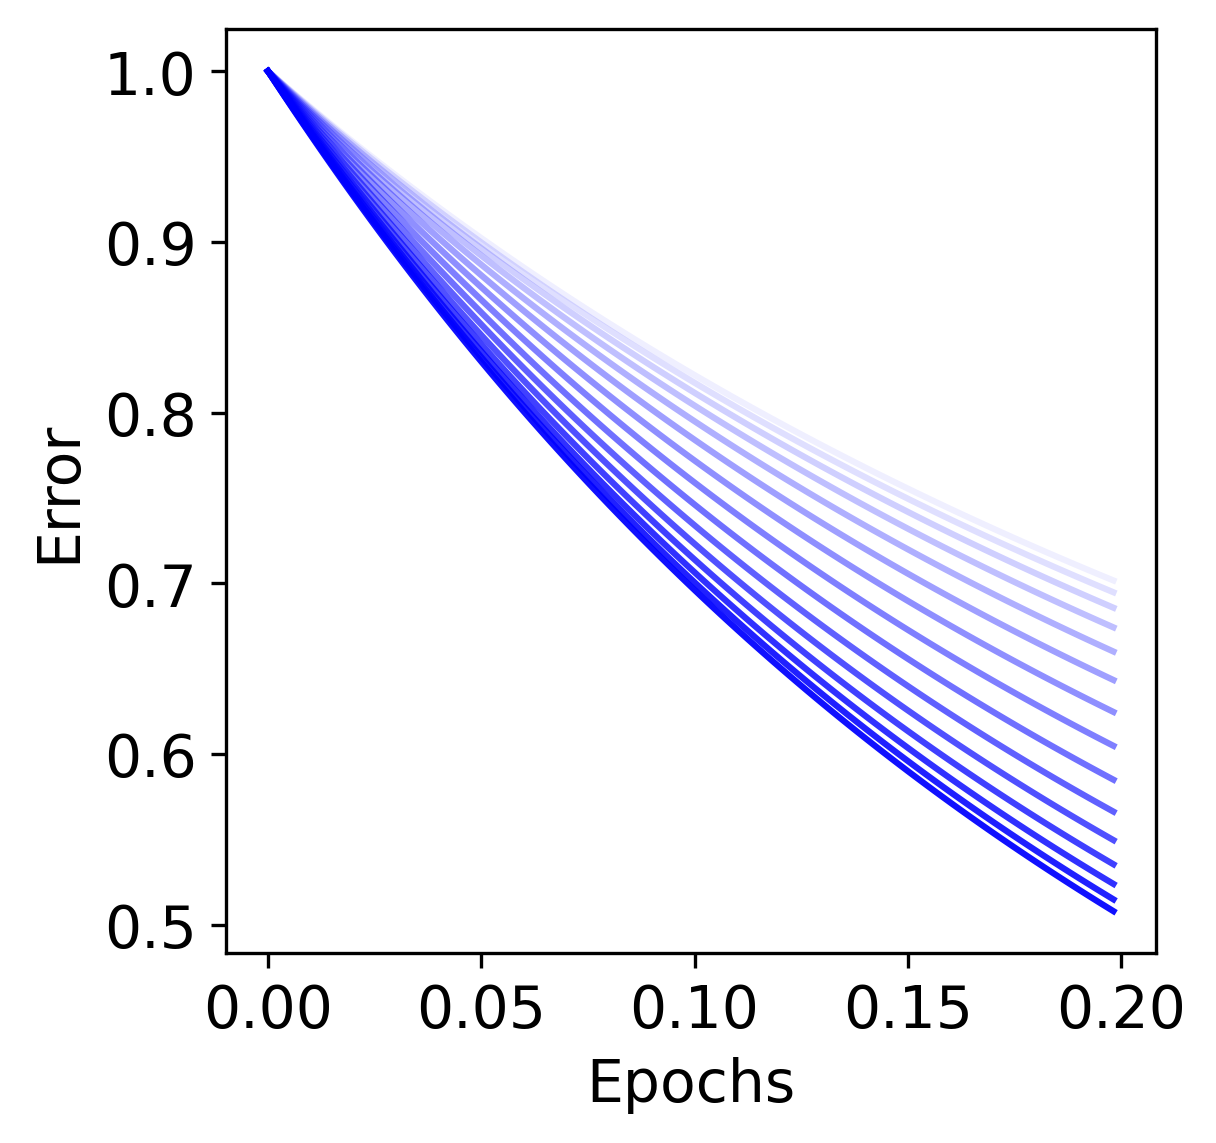

In [11]:
import os
from os.path import exists


# Plot train/test err
t = np.linspace(0.,2,1000)

SNR_vec = np.arange(-4,4,0.5)
SNR = 2**SNR_vec
plt.figure(figsize = (4,4),dpi=300)

#plt.legend()
for i,snr in enumerate(SNR):

    alpha = 1
    phi = 1/snr
    inr = 0
    tau = 1
    Tmax = 10

    lp = (np.sqrt(alpha) + 1)**2
    lm = (np.sqrt(alpha) - 1)**2
    plt.plot(t[0:100],training_error2(t)[0:100],'b',alpha= i/(len(SNR)))

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.savefig('decay_initial.pdf')

plt.show()

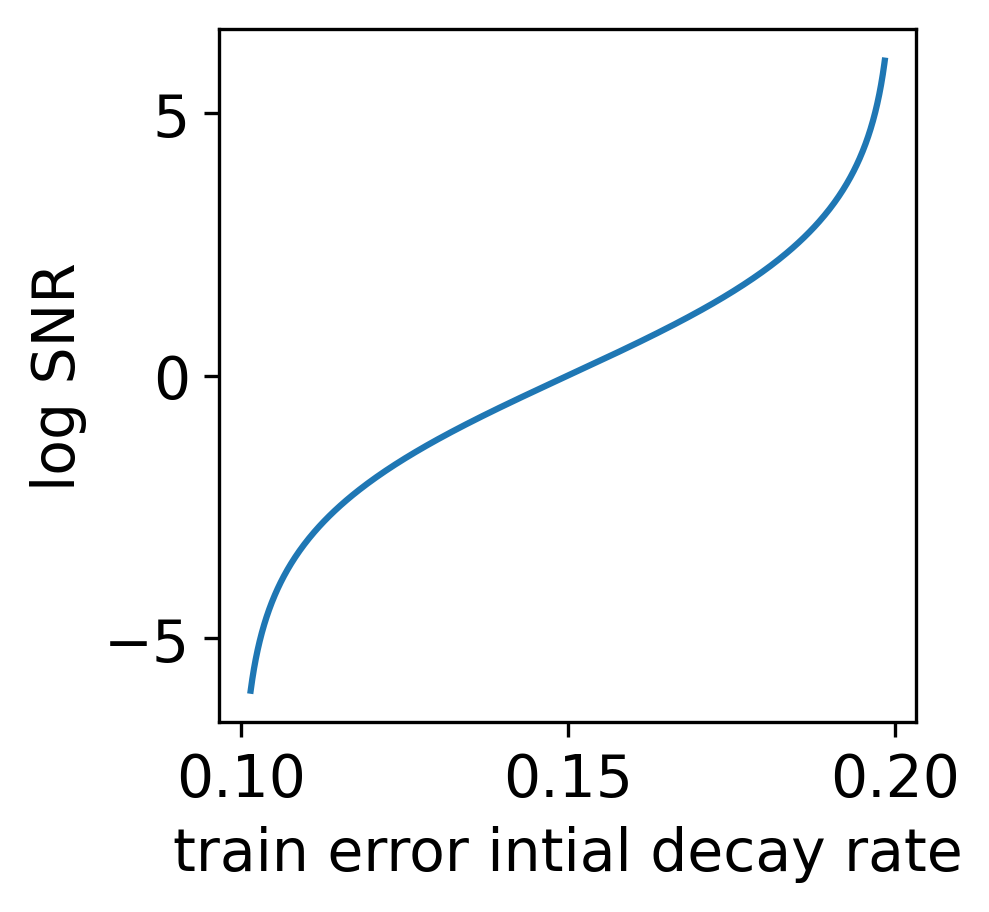

In [12]:
# Plot derivative as fn of SNR
alpha = 1
phi = 1/snr
inr = 0
tau = 1/0.05 #tau = 1/lr
Tmax = 10
def training_error_initial_slope(s):
    point_slope = lambda k: 1./alpha * sp.integrate.quad(lambda x: pMP_nz_scalar(x)*(1+x*k)/(1+k)*(-2*x/tau), 0, np.inf)[0]
    return np.array([point_slope(x) for x in s])


s = np.logspace(-6,6,num=600,base = 2)

slopes_table = training_error_initial_slope(s)


# plt.plot(s,slopes_table)
# plt.xlabel('SNR')
# plt.ylabel('d/dt train error')
# plt.show()


plt.figure(figsize = (3,3),dpi =300)
plt.plot(-slopes_table,np.log2(s))
plt.ylabel('log SNR')
plt.xlabel('train error intial decay rate')
plt.savefig('look_up_table.pdf')
plt.show()

In [16]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


class TSN():

    def __init__(self, input_dim, output_dim, P, P_test, SNR, lr = 0.05, rand_seed = 101):
        self.N = input_dim
        self.output_dim = output_dim
        self.P = P
        self.P_test = P_test
        self.variance_w = snr_to_var(SNR)[0]
        self.variance_e = snr_to_var(SNR)[1]
        self.lr = lr
        torch.manual_seed(rand_seed)
        noise_train = torch.normal(0, self.variance_e**0.5, size = [self.P,1])
        noise_test = torch.normal(0, self.variance_e**0.5, size = [self.P_test,1])
        W_t = torch.normal(0, self.variance_w**0.5, size=(self.N, 1))
        self.train_x = torch.normal(0, (1/self.N)**0.5, size=(self.P, self.N))
        self.train_y = torch.matmul(self.train_x, W_t) + noise_train
        self.test_x = torch.normal(0, (1/self.N)**0.5, size=(self.P_test, self.N))
        self.test_y = torch.matmul(self.test_x, W_t) + noise_test

    def training_loop(self, nepoch = 1000, reg_strength = 0):

        model = nn.Sequential(nn.Linear(self.N,self.output_dim,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=self.lr*(self.N/2), weight_decay = reg_strength) # to match the learnrate in the matlab implementation.
        optimizer.zero_grad()

        with torch.no_grad():
             list(model.parameters())[0].zero_()

        Et = np.zeros((nepoch,1))
        Eg = np.zeros((nepoch,1))
        print_iter = 200

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(self.train_y, model(self.train_x))
            train_error.backward()
            optimizer.step()
            Et[i] = train_error.detach().numpy()
            with torch.no_grad():
                 test_error = criterion(self.test_y, model(self.test_x))
                 Eg[i] = test_error.numpy()
            # if i%print_iter == 0:
            #    print('Et '+ str(Et[i].item()),'Eg '+ str(Eg[i].item()),str(i*100/nepoch) + '% Finished')

        return Et, Eg

class TSN_validation():

    def __init__(self, input_dim, output_dim, P, P_test, SNR, lr = 0.05, rand_seed = 101):
        self.N = input_dim
        self.output_dim = output_dim
        self.P = P
        self.P_test = P_test
        self.variance_w = snr_to_var(SNR)[0]
        self.variance_e = snr_to_var(SNR)[1]
        self.lr = 0.05
        torch.manual_seed(rand_seed)
        noise_train = torch.normal(0, self.variance_e**0.5, size = [self.P,1])
        noise_test = torch.normal(0, self.variance_e**0.5, size = [self.P_test,1])
        W_t = torch.normal(0, self.variance_w**0.5, size=(self.N, 1))
        self.train_x = torch.normal(0, (1/self.N)**0.5, size=(self.P, self.N))
        self.train_y = torch.matmul(self.train_x, W_t) + noise_train
        self.test_x = torch.normal(0, (1/self.N)**0.5, size=(self.P_test, self.N))
        self.test_y = torch.matmul(self.test_x, W_t) + noise_test

    def training_loop(self, nepoch = 2000, reg_strength = 1e-2):

        model = nn.Sequential(nn.Linear(self.N,self.output_dim,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=self.lr*(self.N/2), weight_decay= reg_strength) # to match the learnrate in the matlab implementation.
        optimizer.zero_grad()

        with torch.no_grad():
             list(model.parameters())[0].zero_()

        Et = np.zeros((nepoch,1))
        Eg = np.zeros((nepoch,1))
        print_iter = 200

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(self.train_y, model(self.train_x))
            train_error.backward()
            optimizer.step()
            Et[i] = train_error.detach().numpy()
            with torch.no_grad():
                 test_error = criterion(self.test_y, model(self.test_x))
                 Eg[i] = test_error.numpy()
            # if i%print_iter == 0:
            #    print('Et '+ str(Et[i].item()),'Eg '+ str(Eg[i].item()),str(i*100/nepoch) + '% Finished')

        return Et, Eg

def snr_to_var(SNR):
    if SNR == np.inf:
        variance_w = 1
        variance_e = 0
    else:
        variance_w = SNR/(SNR + 1)
        variance_e = 1/(SNR + 1)
    return variance_w, variance_e

def criterion(y, y_hat):
    return (y - y_hat).pow(2).mean()

In [19]:
# from task import TSN

N = 3000
out_dim = 1
P =3000
P_test = 1000
lr_tsn = 0.05
nepoch_tsn = 100

In [ ]:
#SNR_vec = np.arange(0.02,5,0.02)

SNR_vec = np.arange(-4,4,0.02)
SNR_vec = 2**SNR_vec
SNR_vec = np.repeat(SNR_vec,10) #generate multiple teachers for each SNR

alt_train = torch.zeros(len(SNR_vec),nepoch_tsn)
alt_test = torch.zeros(len(SNR_vec),nepoch_tsn)

SNR_train = torch.zeros(len(SNR_vec),1)
SNR_test = torch.zeros(len(SNR_vec),1)

for i,SNR in enumerate(SNR_vec):

    if SNR == np.inf:
        variance_w = 1;
        variance_e = 0;
    else:
        variance_w = SNR/(SNR + 1);
        variance_e = 1/(SNR + 1);

    # generate learning trajectories
    teacher = TSN(N,out_dim, P, P_test,SNR,lr_tsn,i)

    Et, _ = teacher.training_loop(nepoch_tsn,0)

    alt_train[i,:] = torch.tensor(np.squeeze(Et))
    SNR_train[i,:] = SNR

train_final = torch.diff(alt_train)


plt.scatter(np.log2(SNR_train),train_final[:,0])

In [ ]:
def predict_SNR(lookup_table,values,SNRs):
    lookup_table = np.asarray(lookup_table)
    predicted_SNRs =  np.zeros((len(values),1))

    for i,value in enumerate(values):
        idx = (np.abs(lookup_table - value)).argmin()
        predicted_SNRs[i] = SNRs[idx]
    return predicted_SNRs

In [ ]:
result  = predict_SNR(slopes_table,train_final[:,0].numpy(),np.log2(s))

In [ ]:
plt.figure(figsize = (5,5),dpi = 300)
plt.scatter(np.log2(SNR_train), result,s=30, facecolors='none', edgecolors='k')
plt.xlim(-6,6)
plt.xticks(np.arange(-6, 8, 2))

plt.ylim(-6,6)
plt.yticks(np.arange(-6, 8, 2))


plt.savefig('Rate_scatter.pdf')